<a href="https://colab.research.google.com/github/dnkhiem/Crypto-prediction/blob/master/stock_predict_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
! ls /content/gdrive/"My Drive"/LSTM_train

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
weights2.hdf5  weights4.hdf5	weights5.hdf5
weights3.hdf5  weights5_2.hdf5	weights.hdf5


In [2]:
!pip install tensorflow==2.0.0
!pip install python-binance

#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/dnkhiem/Crypto-prediction/master/original_data/data_numpy_1h.csv?token=AEFIVV7W4WNC7F7MOMS7TRK57QRBK \
#    -O tmp/data_numpy_1h.csv

     |████████████████████████████████| 86.3MB 71kB/s 
     |████████████████████████████████| 450kB 41.2MB/s 
     |████████████████████████████████| 3.8MB 31.0MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

     |████████████████████████████████| 358kB 7.8MB/s 
     |████████████████████████████████| 778kB 42.2MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 3.1MB 43.2MB/s 
     |████████████████████████████████| 2.3MB 30.8MB/s 
     |████████████████████████████████| 174kB 45.5MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 


In [0]:
from binance.client import Client
import os

import tensorflow as tf
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
from datetime import datetime

api_key = '9dCDlPKBoql51ImypE4NDCRwq68fFlav2Ttf3OfRJliZb6jQAZze7hWY20ez1K73'
api_secret = '2xLoIawNjTYL2rImE7RemR3GleQFaqz6WKhrYsXlqV5cFfRhuzLzHAlU18DKlLHu'



In [0]:
def get_data_from_binance(client, symbol, time_candle, time_begin = "1 Jan, 2017"):
    time_dict = {
        '15m':Client.KLINE_INTERVAL_15MINUTE,
        '30m':Client.KLINE_INTERVAL_30MINUTE,
        '1h':Client.KLINE_INTERVAL_1HOUR,
        '2h':Client.KLINE_INTERVAL_2HOUR,
        '4h':Client.KLINE_INTERVAL_4HOUR,
        '6h':Client.KLINE_INTERVAL_6HOUR,
        '8h':Client.KLINE_INTERVAL_8HOUR,
        '12h':Client.KLINE_INTERVAL_12HOUR,
        '1d':Client.KLINE_INTERVAL_1DAY,
        '3d':Client.KLINE_INTERVAL_3DAY,
        }
    klines = client.get_historical_klines(symbol, time_dict[time_candle], time_begin, "now UTC")   
    return klines

def get_data(client, symbol, cols, time_scale, update_data = True):
    filename = '/tmp/data_numpy_' + str(time_scale) + '.csv'
    data_cols_label = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 
                           'Close Time', 'Quote asset volume', 'Number of trades',
                           ' Taker buy base asset volume', 'Taker buy quote asset volume',
                           'Ignore']
    if os.path.exists(filename):
        print('file exists')
        df1 = pd.read_csv(filename) 
        if update_data == False:
            return df1.astype(float)
        timestamp = df1.iloc[-1, 0]
        dt_object = datetime.fromtimestamp(timestamp*1e-3)
        time_begin = dt_object.strftime('%d %b, %Y')        
        datas = get_data_from_binance(client, symbol, time_candle = time_scale, time_begin = time_begin)
        df2 = pd.DataFrame(datas)
        df2.set_axis(data_cols_label, axis='columns', inplace=True)
        df2 = df2.iloc[:,cols]
        df2.index.name = 'Index'
        #combine 2 dataframe
        time_str = datetime.strptime(time_begin, '%d %b, %Y')
        time_stamp_begin = int(datetime.timestamp(time_str) *1000)
        print(time_stamp_begin)
        print(df1[df1.loc[:,'Open time'] == time_stamp_begin])
        index_combine = df1[df1.loc[:,'Open time'] == time_stamp_begin].index[0]
        df1 =df1.iloc[:index_combine]
        df3 = pd.concat([df1, df2], ignore_index=True)
        df3.to_csv(filename, index=False)
        return df3.astype(float)
    else:        
        datas = get_data_from_binance(client, symbol, time_candle = time_scale)
#    data_numpy = np.asarray(datas, np.float32)    
        df = pd.DataFrame(datas) 
        df.set_axis(data_cols_label, axis='columns', inplace=True)
        df.index.name = 'Index'
        df2 = df.iloc[:-1,cols]
        df2.to_csv(filename, index=False)
        return df2.astype(float)


In [0]:
def get_SMA(data, n_candles = 20):
  SMA_candles =[]
  print(data.shape)
  for i in range(1, data.shape[0] + 1):
    i_begin = max(0, i - n_candles)
    SMA_candles.append(np.average(data[i_begin:i]))
  return SMA_candles

def get_EMA(data, n_candles = 20):
  EMA_candles =[]
  EMA_candles.append(data[0])
  print(data.shape)
  k = 2.0/ (1 + n_candles)
  for i in range(1, data.shape[0]):
    EMA_current = data[i] * k + EMA_candles[-1] * (1 - k)
    EMA_candles.append(EMA_current)
  return EMA_candles


In [6]:
client = Client(api_key, api_secret)
symbol = 'BTCUSDT'
cols = [0, 1, 2, 3, 4, 5]
data1 = get_data(client, symbol, cols, time_scale = '4h', update_data = False)
data1['Open'] = data1['Open']
data1['High'] = data1['High']
data1['Low'] = data1['Low']
data1['Close'] = data1['Close']

SMA_candles_20 = get_SMA(np.array(data1['Close']), n_candles = 20)
SMA_candles_50 = get_SMA(np.array(data1['Close']), n_candles = 50)

EMA_candles_20 = get_EMA(np.array(data1['Close']), n_candles = 20)
EMA_candles_50 = get_EMA(np.array(data1['Close']), n_candles = 50)

#avg_candles_200 = get_avg_candles(np.array(data1['Avg']), n_candles = 200)
#data1['SMA_20'] = SMA_candles_20
#data1['SMA_50'] = SMA_candles_50

data1['EMA_20'] = EMA_candles_20
data1['EMA_50'] = EMA_candles_50

data1['Avg'] = (data1['Open'] + data1['Close'])/2
#data1['avg_200'] = avg_candles_200

(5173,)
(5173,)
(5173,)
(5173,)


In [0]:
#print(np.array(data1['Avg']))
#print(avg_candles_20)

In [0]:
def windowed_dataset(data_in, windows = 30):
    data_out = np.zeros((data_in.shape[1], data_in.shape[0] - windows+1, windows))
    print(data_in.shape)
    print(data_out.shape)
    for i in range(data_in.shape[0] - windows+1):  
        data_out[:,i,:] = data_in.T[:,i:i+windows]
    return data_out


In [0]:
def get_data_train(data, cols, windows = 42, train_ratio = 0.9):
    data_in = np.array(data.iloc[:,cols])
    for i in range(data_in.shape[0]):
      if (data_in[i, 1] - data_in[i, -1]) / data_in[i, -1] > 0.05:
        if data_in[i, 1] - max(data_in[i, 0], data_in[i, 3]) > max(data_in[i, 0], data_in[i, 3]) - data_in[i, -1]:
          data_in[i, 1] = max (2 * max(data_in[i, 0], data_in[i, 3]) - data_in[i, -1], data_in[i, -1]*1.03)
      if (- data_in[i, 2] + data_in[i, -1]) / data_in[i, -1] > 0.05:
        if - data_in[i, 2] + min(data_in[i, 0], data_in[i, 3]) > - min(data_in[i, 0], data_in[i, 3]) + data_in[i, -1]:
          data_in[i, 2] = min( 2 * min(data_in[i, 0], data_in[i, 3]) - data_in[i, -1], data_in[i, -1]*0.97)
    print(data_in[25:30,:])
    data_in = data_in[10:,:-1]
    data_for_LSTMs = windowed_dataset(data_in, windows)
    
    n_data = data_for_LSTMs.shape[1]
    print(data_for_LSTMs.shape)
    split_time = int(n_data * train_ratio)
    
    X_train = data_for_LSTMs[:,:split_time,:]
    y_train = data_in[windows:windows + split_time,[1, 2, 3]]
    
    X_valid = data_for_LSTMs[:,split_time:-1,:]
    y_valid = data_in[windows + split_time:,[1, 2, 3]]
    
    X_train = np.transpose(X_train, (1, 2, 0))
    X_valid = np.transpose(X_valid, (1, 2, 0))
    
    return X_train, y_train, X_valid, y_valid

In [10]:
windows = 42
cols_for_LSTMs = [1, 2, 3, 4, 5, 6, 7, 8]
X_train, y_train, X_valid, y_valid = get_data_train(data1, cols_for_LSTMs, windows= windows, train_ratio = 0.80)
#history, model = build_model_find_lr(X_train, y_train, X_valid, y_valid)



[[4043.63       4088.12       4000.01       4023.11         78.878314
  4128.32519986 4214.49502115 4033.37      ]
 [4023.11       4023.11       3911.79       4022.           43.762796
  4118.19899035 4206.94619679 4022.555     ]
 [4005.99       4042.11       3918.8        4027.05         24.46693
  4109.51813412 4199.89144397 4016.52      ]
 [4027.05       4070.49       3950.         4016.          101.221748
  4100.61164516 4192.6800148  4021.525     ]
 [4016.         4016.         3785.585      3862.39        114.685346
  4077.92386943 4179.7274652  3939.195     ]]
(5163, 7)
(7, 5122, 42)
(7, 5122, 42)


In [11]:
print(X_valid[1:6,-1,1:4])
print(y_valid[:5])

[[11720.   11073.   11651.35]
 [11749.   11541.   11654.69]
 [11717.35 11429.02 11475.  ]
 [11649.98 11401.1  11590.  ]
 [11885.   11586.   11757.22]]
[[11720.   11073.   11651.35]
 [11749.   11541.   11654.69]
 [11717.35 11429.02 11475.  ]
 [11649.98 11401.1  11590.  ]
 [11885.   11586.   11757.22]]


In [12]:
print(y_train[50:55,:])

[[4714.76 4584.78 4620.87]
 [4674.86 4456.8  4486.  ]
 [4557.25 4298.33 4384.15]
 [4530.   4345.01 4529.  ]
 [4583.84 4445.15 4509.08]]


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 450 and logs.get('val_mae')<50):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

#checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#cp_callback = tf.keras.callbacks.ModelCheckpoint(
#    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
 #   period=50)


In [0]:
def separate_block(input_tensor, n_LSTMs = 16, n_Dense = 16):
  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_tensor)
  x = tf.keras.layers.Conv1D(n_LSTMs, 5, activation = 'relu') (x) # test with Conv1D
#  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
 
  x = tf.keras.layers.LSTM(n_LSTMs, return_sequences=True)(x)
#  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.LSTM(n_LSTMs)(x)
#  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
#  x = tf.keras.layers.Dense(n_Dense, activation="relu")(x)
  return x

def separate_block_update(input_tensor, n_LSTMs = 16, n_Dense = 16):
#  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_tensor)
  x = tf.keras.layers.Conv1D(n_LSTMs, 5, activation = 'relu') (input_tensor) # test with Conv1D
  x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_LSTMs, return_sequences=True))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_LSTMs))(x)
#  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(n_Dense, activation="relu")(x)
  return x

In [0]:
def build_model_find_lr(X_train, y_train, X_valid, y_valid):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    input_data = tf.keras.layers.Input(shape = [None, 7])

    x = tf.keras.layers.Conv1D(64, 5, activation = 'relu') (input_data) # test with Conv1D
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)
#    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Dense(64, activation="relu")(x)
#    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1)(x)

    model = tf.keras.models.Model(input_data, x)
    model.summary()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    history = model.fit(X_train, y_train, epochs=80, callbacks=[lr_schedule], verbose = 2)
    
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-6, 1e-1, 00, 1])
    
    return history, model

#history_test, model_test = build_model_find_lr(X_train, y_train, X_valid, y_valid)

In [0]:
def build_model_V3(X_train, y_train, X_valid, y_valid, load_model = True):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    input_data = tf.keras.layers.Input(shape = [None, 7])

############################################################################
    x0 = separate_block(input_data[:,:, 0], 16, 16)
    x1 = separate_block(input_data[:,:, 1], 16, 16)
    x2 = separate_block(input_data[:,:, 2], 16, 16)
    x3 = separate_block(input_data[:,:, 3], 64, 64)
    x4 = separate_block(input_data[:,:, 4], 64, 64)
    x5 = separate_block(input_data[:,:, 5], 32, 32)
    x6 = separate_block(input_data[:,:, 6], 32, 32)
#    x7 = separate_block(input_data[:,:, 7], 32, 32)
#    x8 = separate_block(input_data[:,:, 8], 32, 32)
    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4, x5, x6])
############################################################################
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(3)(x)

    model = tf.keras.models.Model(input_data, x)
    model.summary()

    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
              optimizer = 'adam',
              metrics=["mae"])
    path = '/content/gdrive/My Drive/LSTM_train/weights3.hdf5'
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=2, save_best_only=True)
    if load_model:
      model.load_weights(path)
    history = model.fit(X_train, y_train, epochs=1000, batch_size= 32, 
                        validation_data=(X_valid, y_valid), verbose = 2, 
                        #callbacks = [callback, checkpointer])
                        callbacks = [checkpointer])
    return history, model

#history, model = build_model(X_train, y_train, X_valid, y_valid, load_model = False)

In [0]:
def build_model_V4(X_train, y_train, X_valid, y_valid, load_model = True):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    LSTM_input = tf.keras.layers.Input(shape = [None, 7])
    Dense_input = tf.keras.layers.Input(shape = [42,7])
############################################################################
    x0 = separate_block(LSTM_input[:,:, 0], 16, 16)
    x1 = separate_block(LSTM_input[:,:, 1], 16, 16)
    x2 = separate_block(LSTM_input[:,:, 2], 16, 16)
    x3 = separate_block(LSTM_input[:,:, 3], 64, 64)
    x4 = separate_block(LSTM_input[:,:, 4], 64, 64)
#    x5 = separate_block(LSTM_input[:,:, 5], 16, 16)
#    x6 = separate_block(LSTM_input[:,:, 6], 16, 16)
    
#    x7 = separate_block(LSTM_input[:,:, 7], 32, 32)
#    x8 = separate_block(LSTM_input[:,:, 8], 32, 32)
    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])
    LSTM_branch = tf.keras.models.Model(LSTM_input, x)
############################################################################
#    y1 = tf.keras.layers.Dense(32, activation="relu")(Dense_input[:,3])
#    y1 = tf.keras.layers.Dropout(0.2)(y1)
#    y2 = tf.keras.layers.Dense(32, activation="relu")(Dense_input[:,4])
#    y2 = tf.keras.layers.Dropout(0.2)(y2)
    y3 = tf.keras.layers.Dense(32, activation="relu")(Dense_input[:,5])
#    y3 = tf.keras.layers.Dropout(0.2)(y3)
    y4 = tf.keras.layers.Dense(32, activation="relu")(Dense_input[:,6])
#    y4 = tf.keras.layers.Dropout(0.2)(y4)
    y = tf.keras.layers.concatenate([y3, y4])
    technical_indicators_branch = tf.keras.models.Model(inputs=Dense_input, outputs=y)

    combined = tf.keras.layers.concatenate([LSTM_branch.output, 
                                            technical_indicators_branch.output])
    z = tf.keras.layers.Dense(256, activation="relu")(combined)
    z = tf.keras.layers.Dropout(0.2)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.Dense(64, activation="relu")(z)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.Dense(3, activation="linear", name='dense_out')(z)

#    x = tf.keras.layers.Dense(128, activation="relu")(x)
#    x = tf.keras.layers.Dropout(0.2)(x)
#    x = tf.keras.layers.BatchNormalization()(x)
#    x = tf.keras.layers.Dense(3)(x)
    model = tf.keras.models.Model(inputs=[LSTM_branch.input, 
                                     technical_indicators_branch.input], 
                             outputs=z)
    
    model.summary()

    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
              optimizer = 'adam',
              metrics=["mae"])
    path = '/content/gdrive/My Drive/LSTM_train/weights4.hdf5'
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=2, save_best_only=True)
    if load_model:
      model.load_weights(path)
    history = model.fit(x=[X_train, X_train], 
                        y = y_train, 
                        epochs=1000, 
                        batch_size= 32, 
                        validation_data=([X_valid, X_valid], y_valid), 
                        verbose = 2, 
                        #callbacks = [callback, checkpointer])
                        callbacks = [checkpointer])
    return history, model

#history, model = build_model_V4(X_train, y_train, X_valid, y_valid, load_model = True)

In [0]:
def build_model_V5_1(X_train, y_train, X_valid, y_valid, load_model = True):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    input_data = tf.keras.layers.Input(shape = [None, 7])

############################################################################
    x = tf.keras.layers.Conv1D(128, 5, activation = 'relu') (input_data) # test with Conv1D
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x0 = separate_block(input_data[:,:, 0], 16, 16)
    x1 = separate_block(input_data[:,:, 1], 16, 16)
    x2 = separate_block(input_data[:,:, 2], 16, 16)
    x3 = separate_block(input_data[:,:, 3], 64, 64)
    x4 = separate_block(input_data[:,:, 4], 64, 64)
    x5 = separate_block(input_data[:,:, 5], 32, 32)
    x6 = separate_block(input_data[:,:, 6], 32, 32)
#    x7 = separate_block(input_data[:,:, 7], 32, 32)
#    x8 = separate_block(input_data[:,:, 8], 32, 32)
    x = tf.keras.layers.concatenate([x, x0, x1, x2, x3, x4, x5, x6])
############################################################################
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(3)(x)

    model = tf.keras.models.Model(input_data, x)
    model.summary()

    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov = True)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
 #             optimizer = 'adam',
              metrics=["mse"])
    path = '/content/gdrive/My Drive/LSTM_train/weights5.hdf5'
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=2, save_best_only=True)
    if load_model:
      model.load_weights(path)
    history = model.fit(X_train, y_train, epochs=1000, batch_size= 32, 
                        validation_data=(X_valid, y_valid), verbose = 2, 
                        #callbacks = [callback, checkpointer])
                        callbacks = [checkpointer])
    return history, model

#history, model = build_model_V5_1(X_train, y_train, X_valid, y_valid, load_model = True)

In [0]:
def separate_block_V5_2(input_tensor, n_LSTMs = 16, n_Dense = 16):
  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_tensor)
  x = tf.keras.layers.Conv1D(n_LSTMs, 5) (x) # test with Conv1D
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(activation = 'relu') (x)
  x = tf.keras.layers.Dropout(0.2)(x)
 
  x = tf.keras.layers.LSTM(2* n_LSTMs, return_sequences=True)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.LSTM(n_LSTMs)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
#  x = tf.keras.layers.Dense(n_Dense, activation="relu")(x)
  return x

def build_model_V5_2(X_train, y_train, X_valid, y_valid, load_model = True):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    input_data = tf.keras.layers.Input(shape = [None, 7])

############################################################################
    x = tf.keras.layers.Conv1D(128, 5) (input_data) # test with Conv1D
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = 'relu') (x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x0 = separate_block_V5_2(input_data[:,:, 0], 16, 16)
    x1 = separate_block_V5_2(input_data[:,:, 1], 16, 16)
    x2 = separate_block_V5_2(input_data[:,:, 2], 16, 16)
    x3 = separate_block_V5_2(input_data[:,:, 3], 64, 64)
    x4 = separate_block_V5_2(input_data[:,:, 4], 64, 64)
    x5 = separate_block_V5_2(input_data[:,:, 5], 32, 32)
    x6 = separate_block_V5_2(input_data[:,:, 6], 32, 32)
#    x7 = separate_block(input_data[:,:, 7], 32, 32)
#    x8 = separate_block(input_data[:,:, 8], 32, 32)
    x = tf.keras.layers.concatenate([x, x0, x1, x2, x3, x4, x5, x6])
############################################################################
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = 'relu') (x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(3)(x)

    model = tf.keras.models.Model(input_data, x)
    model.summary()

    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov = True)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
 #             optimizer = 'adam',
              metrics=["mae"])
    path = '/content/gdrive/My Drive/LSTM_train/weights5_2.hdf5'
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=2, save_best_only=True)
    if load_model:
      model.load_weights(path)
    history = model.fit(X_train, y_train, epochs=500, batch_size= 32, 
                        validation_data=(X_valid, y_valid), verbose = 2, 
                        #callbacks = [callback, checkpointer])
                        callbacks = [checkpointer])
    return history, model

history, model = build_model_V5_2(X_train, y_train, X_valid, y_valid, load_model = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, None)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, None)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, None)]       0           input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
#print(min(history.history['mae']))
#print(min(history.history['val_mae']))
#print(min(history2.history['mae']))
#print(min(history2.history['val_mae']))

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, val_mae, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = mae[50:]
loss_zoom = val_mae[50:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

NameError: ignored

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, None)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, None)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, None)]       0           input_1[0][0]                    
______________________________________________________________________________________________

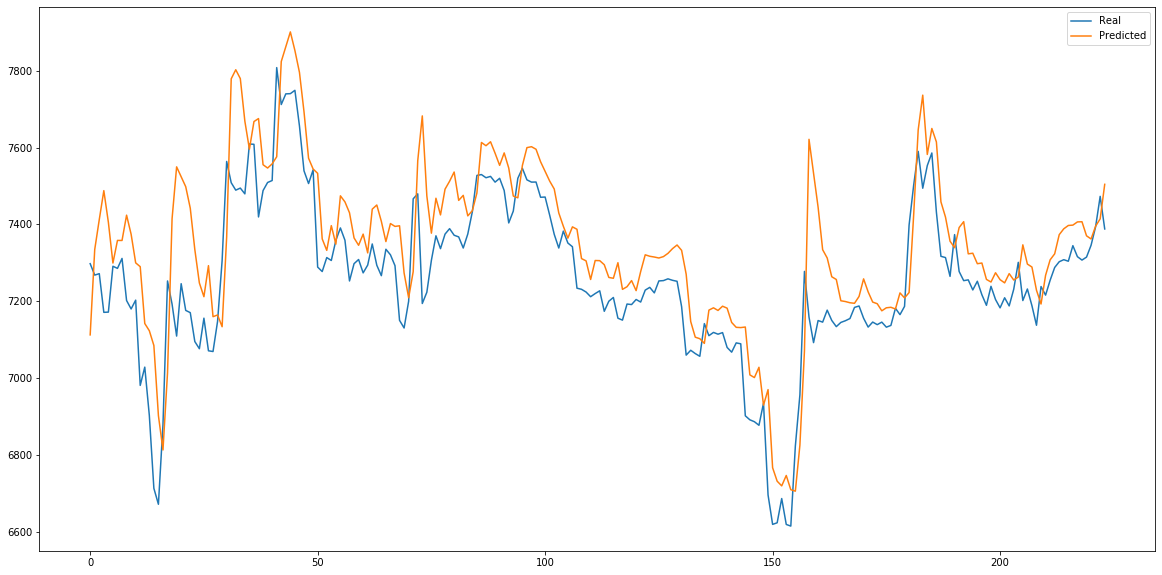

In [22]:
def test_model(X_valid):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    batch_size = 32
    epochs = 50
    callback = myCallback()
    input_data = tf.keras.layers.Input(shape = [None, 7])

############################################################################
    x = tf.keras.layers.Conv1D(128, 5) (input_data) # test with Conv1D
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = 'relu') (x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x0 = separate_block_V5_2(input_data[:,:, 0], 16, 16)
    x1 = separate_block_V5_2(input_data[:,:, 1], 16, 16)
    x2 = separate_block_V5_2(input_data[:,:, 2], 16, 16)
    x3 = separate_block_V5_2(input_data[:,:, 3], 64, 64)
    x4 = separate_block_V5_2(input_data[:,:, 4], 64, 64)
    x5 = separate_block_V5_2(input_data[:,:, 5], 32, 32)
    x6 = separate_block_V5_2(input_data[:,:, 6], 32, 32)
#    x7 = separate_block(input_data[:,:, 7], 32, 32)
#    x8 = separate_block(input_data[:,:, 8], 32, 32)
    x = tf.keras.layers.concatenate([x, x0, x1, x2, x3, x4, x5, x6])
############################################################################
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = 'relu') (x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(3)(x)

    model = tf.keras.models.Model(input_data, x)
    model.summary()

    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov = True)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
 #             optimizer = 'adam',
              metrics=["mae"])
    path = '/content/gdrive/My Drive/LSTM_train/weights5_2.hdf5'
    model.load_weights(path)
    y_predict = model.predict(X_valid)
    return y_predict
  
y_predict = test_model(X_valid)

import matplotlib.pyplot as plt
plt.gcf().set_size_inches(20, 10, forward=True)

real = plt.plot(y_valid[800:,2], label='real')
pred = plt.plot(y_predict[800:,2], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('model_BTC_predict3.h5')    
model_file = drive.CreateFile({'title' : 'model_BTC_predict3.h5'})
model_file.SetContentFile('model_BTC_predict3.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})